Now that we have created the spectrogram images it's time to build the computer vision model. If you are following along with the learning path then you already created a computer vision model in the second module in this path. We will be creating a computer vision model -- they may look familiar! Like always we first import the packages we need to build the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd

## Load Spectrogram images into a dataset for training

Here we provide the path to our image data and use [tf.keras.preprocessing.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) to load the images into tensors. 

This method is doing a lot for us. Lets take a look at a few of the params:
- `labels='inferred'`: The labels are created based on folder directory names.
- `image_size=(256, 256)`: resizes the image
- `validation_split=0.2, subset='validation'`: create validation dataset

In [16]:
train_directory = './data/train/'
test_directory = './data/test/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123, 
    validation_split=0.2, subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 6741 files belonging to 3 classes.
Using 1348 files for validation.
Found 3372 files belonging to 3 classes.
['dog', 'no', 'yes']


## Display spectrogram images

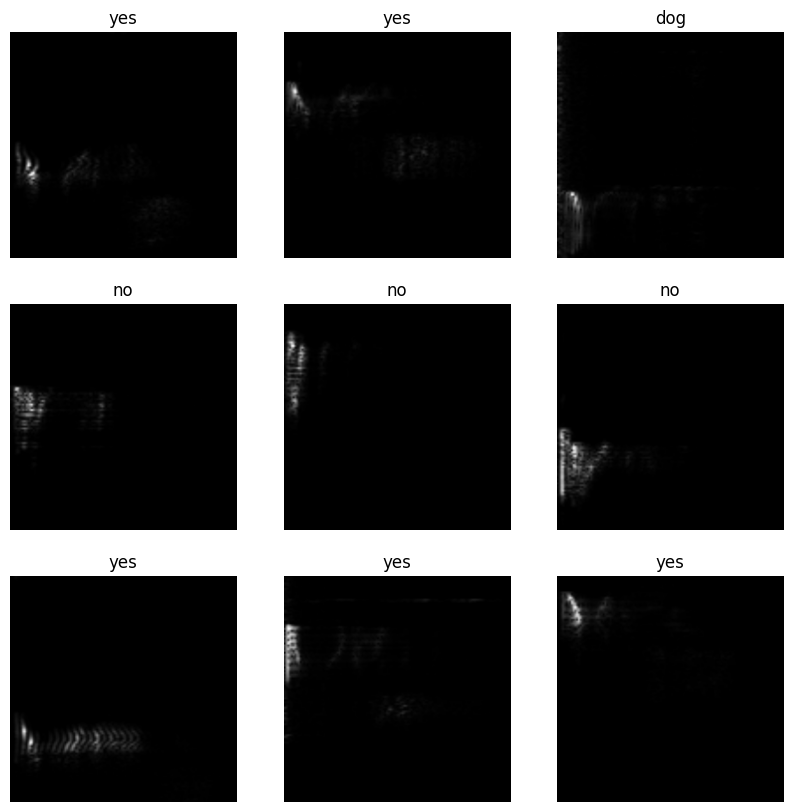

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Create the model

We are ready to create the Convolution Neural Network for the computer vision model to process the spectogram images.

To contruct the linear layers we use the [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) and pass in a list with each layer. Read more about the layers [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

In [21]:
num_classes = len(train_ds.class_names)
img_height = 256
img_width = 256

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

- Set the `learning_rate`, loss function `loss_fn`, `optimizer` and `metrics`.

In [22]:
learning_rate = 0.025

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

## Train the model

In [23]:
# Set the epocks
epochs = 30
print('\nFitting:')

# Train the model.
history = model.fit(train_ds, epochs=epochs)


Fitting:
Epoch 1/30
43/43 [==============================] - 16s 364ms/step - loss: 1.0033 - accuracy: 0.5364
Epoch 2/30
43/43 [==============================] - 15s 345ms/step - loss: 0.7762 - accuracy: 0.6721
Epoch 3/30
43/43 [==============================] - 16s 360ms/step - loss: 0.6010 - accuracy: 0.7478
Epoch 4/30
43/43 [==============================] - 15s 352ms/step - loss: 0.5382 - accuracy: 0.7893
Epoch 5/30
43/43 [==============================] - 15s 345ms/step - loss: 0.4585 - accuracy: 0.8086
Epoch 6/30
43/43 [==============================] - 15s 347ms/step - loss: 0.4254 - accuracy: 0.8220
Epoch 7/30
43/43 [==============================] - 15s 348ms/step - loss: 0.3888 - accuracy: 0.8368
Epoch 8/30
43/43 [==============================] - 16s 361ms/step - loss: 0.3461 - accuracy: 0.8657
Epoch 9/30
43/43 [==============================] - 16s 372ms/step - loss: 0.3169 - accuracy: 0.8754
Epoch 10/30
43/43 [==============================] - 16s 364ms/step - loss: 0.298

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

 ## Test the model
 
Awesome! You should have got somewhere between a 93%-95% accuracy by the 15th epoch. Here we grab a batch from our test data and see how the model performs on the test data.

In [25]:
correct = 0
batch_size = 0
for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    pred = model.predict(X)
    for i in range(batch_size):
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1
    break

print(f'Number correct: {correct} out of {batch_size}')
print(f'Accuracy {correct / batch_size}')

1/1 [==============================] - 0s 87ms/step
predicted 1, actual 1
predicted 1, actual 1
predicted 2, actual 2
predicted 2, actual 2
predicted 1, actual 1
predicted 1, actual 1
predicted 2, actual 2
predicted 0, actual 0
predicted 2, actual 2
predicted 2, actual 2
predicted 1, actual 1
predicted 2, actual 2
predicted 0, actual 0
predicted 1, actual 1
predicted 0, actual 1
predicted 1, actual 1
predicted 1, actual 1
predicted 1, actual 1
predicted 2, actual 2
predicted 1, actual 1
predicted 2, actual 2
predicted 2, actual 2
predicted 0, actual 0
predicted 1, actual 1
predicted 2, actual 2
predicted 2, actual 2
predicted 1, actual 1
predicted 0, actual 1
predicted 1, actual 1
predicted 2, actual 2
predicted 1, actual 2
predicted 2, actual 2
Number correct: 29 out of 32
Accuracy 0.90625


## Advanced Optional Step: Test your voice

This optional section allows you to use an audio file of your own voice saying "yes" or "no" and see if the model predicts correctly.  Since it requires you to add your own audio file, you will need to have the ability to record your voice to a wave format and put it in a publically accesible place. The example code has a local directory -- make sure you update the `./data/myvoice/yes.wav` and `./data/myvoice/no.wav` to your data path.

First we'll create a `load_audio` function where we set the `sample_rate` to `16000` and the audio `channels` to `1`, load the file, and use `tfio.audio.resample` to resample the audio to the desired rate.

In [ ]:
def load_audio(file_path):
    sample_rate = 16000
    channels = 1
    audio_binary = tf.io.read_file(file_path)
    audio, original_sample_rate = tf.audio.decode_wav(audio_binary) # desired_samples=sample_rate,desired_channels=channels 
    audio = tfio.audio.resample(audio, original_sample_rate.numpy(), sample_rate)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate

In [ ]:
no_waveform, no_sample_rate = load_audio('./data/myvoice/no.wav')
yes_waveform, yes_sample_rate = load_audio('./data/myvoice/yes.wav')

print(no_waveform.shape)
print(yes_waveform.shape)

- Listen to the audio files now that they have been loaded and resampled.

In [ ]:
ipd.Audio(no_waveform.numpy(), rate=16000)


In [ ]:
ipd.Audio(yes_waveform.numpy(), rate=16000)

- Create a funciton to `get_spectrogram`

In [ ]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    print(len(equal_length))
    
    # Create spectrogram with tfio
    spect = tfio.audio.spectrogram(input=equal_length, nfft=255, window=255, stride=128)
    
    # Or create with tf.signal
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

In [ ]:
no_spectrogram, no_spect = get_spectrogram(no_waveform)
yes_spectrogram, yes_spect = get_spectrogram(yes_waveform)

- Create method `plot_spectrogram` to view your voice spectrogram.

In [ ]:
def plot_spectrogram(spectrogram, ax, title):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, 16000])
    ax.set_title(title)
    
fig, ax = plt.subplots()  
plot_spectrogram(no_spectrogram.numpy(), ax, 'No Spectrogram')
plt.show()

fig, ax = plt.subplots()  
plot_spectrogram(yes_spectrogram.numpy(), ax, 'Yes Spectrogram')
plt.show()

- Save image to local path.

In [ ]:
no_path = './data/myvoice/no_myspec_img.png'
yes_path = './data/myvoice/yes_myspec_img.png'

plt.imsave(no_path, no_spectrogram.numpy(), cmap='gray')
plt.imsave(yes_path, yes_spectrogram.numpy(), cmap='gray')

- Load image to PIL format.

In [ ]:
yes_pil_img = tf.keras.preprocessing.image.load_img(
    yes_path, grayscale=False, color_mode='rgb', target_size=[img_height,img_width],
    interpolation='nearest'
)

no_pil_img = tf.keras.preprocessing.image.load_img(
    no_path, grayscale=False, color_mode='rgb', target_size=[img_height,img_width],
    interpolation='nearest'
)

In [ ]:
yes_pil_img

In [ ]:
no_pil_img

In [ ]:
yes_img_tensor = np.array(yes_pil_img)
no_img_tensor = np.array(no_pil_img)
print(yes_img_tensor.shape)
print(no_img_tensor.shape)



- Now use the model to predict on your voice!

In [ ]:
yes_pred = model.predict(yes_img_tensor[None,:,:])
no_pred = model.predict(no_img_tensor[None,:,:])

yes_predicted = np.argmax(yes_pred)
yes_string_result = 'yes' if yes_predicted == 1 else 'no'

no_predicted = np.argmax(no_pred)
no_string_result = 'yes' if no_predicted == 1 else 'no'

print(f'Prediction for yes is {yes_string_result}')
print(f'Prediction for no is {no_string_result}')
